# Self-Host Services and Serverless Functions

## Introduction

Let's start with a simple case running on a virtual machine then we develop up to a distributed cloud-based model.

1. Build and train a model on a virtual machine such as `Amazon Elastic Compute EC2`. 

2. We can upscale the trained models using serverless services such as `Amazon Lambda` or `Heroku`.

3. Set up API Gateway to control the service

## 1. Self-Host Services / Single Instance

Both AWS and GCP provide `Virtual Machine` cloud services. In this section, we use Amazon EC2.

### 1.1 Amazon Elastic Compute (EC2)

When creating a virtual machine (which is an EC2 instance), create a key-pair (consisting of a private key and a public key, which is a set of security credentials that you use to prove your identity when connecting to an instance), add to the new EC2 instance and download the private key "\*.pem" to access the server via ssh.

![EC2 instance](images/ec2_instance.jpg)

There are 2 IPs

1. Public IP (For SSH, or access Jupyter from external): 54.200.59.160

2. Private IP: 172.31.25.7 - internal IP for this virtual machine. When deploying services on this server, we config with this IP.

To log in, use ssh

```
$ ssh -i ".ssh\Scalable-Model-Pipelines-Key-Pair-Name.pem" ec2-user@ec2-54-200-59-160.us-west-2.compute.amazonaws.com
```


Run Jupyter as background service if you want to work on Jupyter notebook:

```
$ nohup jupyter notebook --ip 172.31.25.7 --notebook-dir ~/codes/ &  
```

To access Jupyter, we need to create an "Inbound Rule" from the Amazon EC2 management website (choose current the security group > Actions > Edit Inbound Rules > Add a new rule to port 8888 by Jupyter)

After starting Jupyter, it will show a URL with a private token like this:

*http://172.31.25.7:8888/?token=02d---------------------------b1*

change this private IP to public IP to run in the local browser.

*http://54.200.59.160:8888/?token=02d---------------------------b1*

**Note**: Activate the env of conda before running jupyter

### 1.2 Dependencies & Prerequisites 

There a couple of additional tools needed:

* google-cloud-bigquery
* google-cloud-sdk
* matplotlib
* pandas
* scikit-learn
* tensorflow

These libraries can be installed via `pip3` or `conda`


### 1.3 Upload Demo Database

I use database from https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv

For uploading, use `scp`. In my case, I simplified database due to my limited resources of EC2 instance.
```
$ scp -i C:\Users\kim_l\.ssh\Scalable-Model-Pipelines-Key-Pair-Name.pem .\train.csv ec2-user@ec2-54-200-59-160.us-west-2.compute.amazonaws.com:~/db/
```

There are thousands of open datasets on Kaggle which is convienient to download and play with.

```
$ pip3 install kaggle

$ kaggle datasets download DB
$ unzip FILE.zip
$ chmod 0600 *.csv
```

### 1.4 Train Models

Depending on what algorithms we want, we can train the models. For purpose of this demo, I use TensorFlow to train with simple tuning.

In reality, if we recommend a user from millions of items, it is not possible to use only one model to predict accurately. The more complex the model is, the more time it takes to predict. Instead, there are multiple-layer models (like a funnel) involved in the predicting process. The top layer will filter out the most irrelevant items/users which might use fast ML algorithms like Linear Regression or even a heuristic filter with no ML involved. At the bottom layer, only tens or hundreds of items are fed to the `ranking model` which should be a neural network that gives very high accuracy.

<img src="images/funnel-model.png" width="50%" />

In this project, I will not focus on building this funnel-based model. I am happy to talk in the other project.

Instead, I build a simple model with `sklearn` supporting seasonality to demo the whole process of building scalable models.

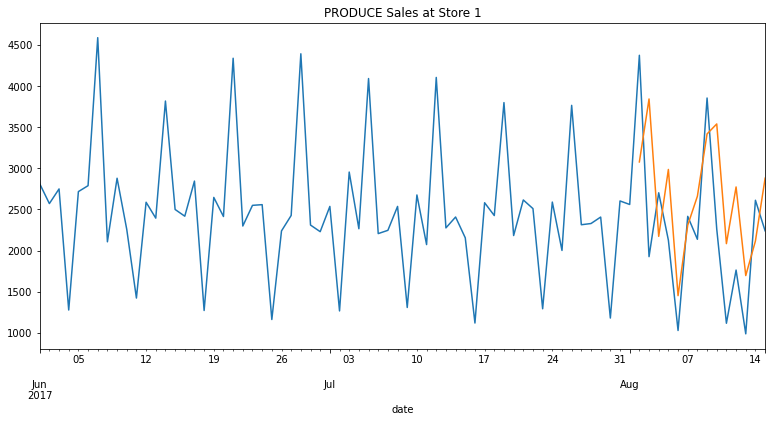

In [1]:
import pandas as pd
from datetime import datetime, date 
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import Fourier,CalendarFourier, DeterministicProcess
import matplotlib.pyplot as plt

##################### Prepare and Process Data #########################
# https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv
db_file = 'db/store-sales-time-series-forecasting.csv'
train_data  = pd.read_csv(db_file, parse_dates=['date'], header=0) 
train_data['date'] = train_data.date.dt.to_period("D")

train_data = train_data.astype({'store_nbr': 'category', 'family': 'category', 'sales': 'float32'})
train_data.drop("onpromotion", axis=1, inplace=True)
train_data = train_data.set_index(['store_nbr', 'family', 'date']).sort_index()

# Training Range
range_begin = "2016-08-01"
range_end   = "2017-08-01"
# Create Labels data (y output)
y = train_data.unstack(['store_nbr', 'family']).loc[range_begin:range_end] 

##################### Creating Training Data #########################
fourier = CalendarFourier(freq='M', order=30)
dp = DeterministicProcess(
    index=y.index,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    period=7,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)  # X.loc["2016-12-31":"2017-01-02"]
##################### Modeling Fitting  ###########################
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

##################### Modeling Predicting #########################
X_test = dp.out_of_sample(steps=15) # Creating Testing Features
X_test['NewYear'] = (X_test.index.dayofyear == 1)
X_test.index.name = 'date'
y_pred   = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

##################### Visualizing ################################
STORE_NBR = 1  # 1 - 54
FAMILY = 'PRODUCE'  # display(store_sales.index.get_level_values('family').unique())
fig, ax = plt.subplots(figsize=(13,6))
train_data.unstack(['store_nbr', 'family']).loc["2017-05-01":"2017-08-15"].loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax.set(xlim=[date(2017, 6, 1),date(2017, 8, 15)] );

### 1.5 Save the Model

In [2]:
######## Save the model ###########
import mlflow.sklearn
model_path = "models/sale_forecasting_sklearn_v1"
mlflow.sklearn.save_model(model, model_path)

######### Save the Seasonality (or DeterministicProcess)
from pickle import dump
# save the scaler
dump(dp, open('models/dp_v1.pkl', 'wb'))
dump(y.columns, open('models/y_columns_v1.pkl', 'wb'))

C:\Users\kim_l\anaconda3\envs\machinelearning\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### 1.6 Web Service Endpoint

Run this `echo.py` to serve the trained model as a Web Service Endpoint.

```python
import pandas as pd
import mlflow.sklearn
import flask
import json
from pickle import load

#### Configure and Load saved model + data ########
model_path = "models/sale_forecasting_sklearn_v1"
dp_path = "models/dp_v1.pkl"
y_column_path = "models/y_columns_v1.pkl"

model = mlflow.sklearn.load_model(model_path)
dp = load(open(dp_path, 'rb'))
y_column = load(open(y_column_path, 'rb'))

############ Start web framework ###################
app = flask.Flask(__name__)

@app.route("/", methods=["GET","POST"])
def predict():
    global model, dp, y_column
    ######## If model is not cached anymore, we can reload it ###########
    if not model or not dp or len(y_column):
        model = mlflow.sklearn.load_model(model_path)
        dp = load(open(dp_path, 'rb'))
        y_column = load(open(y_column_path, 'rb'))
        
    data = {"success": False}
    ############# get Request ##################
    params = flask.request.get_json(silent=True)
    if params is None:
        params = flask.request.args
    ############### If range of date is given, do the prediction ##############
    if "range" in params.keys(): 
        X_pred = dp.out_of_sample(steps=int(params["range"])) # Creating Testing Features
        X_pred['NewYear'] = (X_pred.index.dayofyear == 1)
        X_pred.index.name = 'date'
        y = pd.DataFrame(model.predict(X_pred), index=X_pred.index, columns=y_column)
        data["prediction"] = y.stack(['store_nbr', 'family']).reset_index().to_json()
        data["success"] = True

    return flask.jsonify(data)

if __name__ == '__main__':
    app.run(host='0.0.0.0')
```

Type terminal command:

```
# with Flask built-in web server
$ python echo.py

# with Gunicorn
$ gunicorn --bind 0.0.0.0 echo:app 

# on Window, we can use waitress
$ waitress-serve --listen=127.0.0.1:5000 predict:app
```

## 2. Serverless Technologies

### 2.1 Intro

Serverless functions are an excellent tool for rapidly moving from prototype to production for our predictive models. With serverless function environments, we write a function that the runtime supports, specify a list of dependencies, and then deploy the function to production. The cloud platform is responsible for provisioning servers, scaling up more machines to match demand, managing load balancers, and handling versioning.

* Google Cloud Platform (GCP) provides an environment for serverless functions called Cloud Functions.

* Amazon Lambda does not support `requirements.txt`. We need to install manually by appending `-t .` to the end of the pip command in order to install the libraries into the current directory.

```
pip3 install pandas --no-deps -t .
```

#### Benefit
 The main benefit of this new paradigm is that developers can write code in a staging environment and then push code to production with minimal concerns about operational overhead. Serverless functions are a great approach for demonstrating the ability to serve models at scale.
 
#### Trade-offs

* Iteration: Great for startups by quickly iterating and trying out new architectures.
* Latency: Is a multi-second latency acceptable for our SLAs?
* Scale & Cost: it can be expensive when the system is scaled to match peak workload demands

The top concern is latency because it can impact customer experiences. Serverless ecosystems are restricted to specific runtimes, often have memory limitations that make it challenging to use deep learning frameworks, and are cloud-specific.

### 2.2 Echo Service on Amazon Lambda

Lambda function source code could follow this template

`lambda_function.py` in the top directory:

```python
import LIBRARIES

from pickle import load
LOAD SAVED INFO

def lambda_handler(event, context):
    global model
    if not model:
        LOAD SAVED TRAINED MODEL  
        
    data = {"success": False}
    if "body" in event: 
        event = event["body"]
        
        if event is not None:
            event = json.loads(event)
        else:
            event = {}
            
    if "range" in event: 
        range = int(event["range"])

        FEATURE ENGINEERING               
        X_pred = XXX
        data["prediction"] = str(model.predict(X_pred))
        data["success"] = True

    return data
```

### 2.3 Deploy to Amazon Lambda

#### Zip all current files and upload the zipped file to S3
```
zip -r data.zip .
aws s3 cp data.zip s3://the_S3_bucket/data.zip
```

#### Upload to Lambda

From homepage in Lambda, Choose *Upload from* and choose *Amazon S3 location* then paste the link to zip file.

We can increase RAM, storage, time out in >> configuration >> General configuration

#### API gateway

To let other services can interact with the function, we need to define an API Gateway in the Lambda. Select “Create a new API”. Use the “REST API”.

```python
import requests
result = requests.post("https://LAMBDA-GATEWAY-ADDRESS.amazonaws.com/default/echo",  json = { "range": "15" })
print(result.status_code, result.content)
```

### 2.4 Heroku

Besides Amazon Lambda or , we can host it in the cloud using [`Heroku`](https://www.heroku.com/) which cloud environment suports greatly Python. Heroku supports three main Deployment methods:

1. Heroku Git by using Heroku CLI

```cmd
# log in to your Heroku
$ heroku login
# Clone the repository
$ heroku git:clone -a scalable-model-piplines 
$ cd scalable-model-piplines
# Deploy your changes
$ git add .
$ git commit -am "make it better"
$ git push heroku master
```

2. GitHub by connecting to a GitHub project.

3. Run Docker-based Container

Heroku was free until November 28, 2022. But this enviroment is low cost and may be suitable for short-term developing.